# Part 1
#### Importing libraries

In [1]:
import pytz
import torch
from PIL import Image
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.optim import SGD
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
from torch.utils.data import Dataset
import time
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
from torch.autograd import Variable
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

zip_file = '/content/drive/MyDrive/Datasets/MMU-Iris-Database.zip'
extract_folder = '/content/'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Part 2
#### loading train data

10125
index number:  0
Label: 0.0


index number:  1
Label: 0.0


index number:  2
Label: 0.0


index number:  3
Label: 0.0


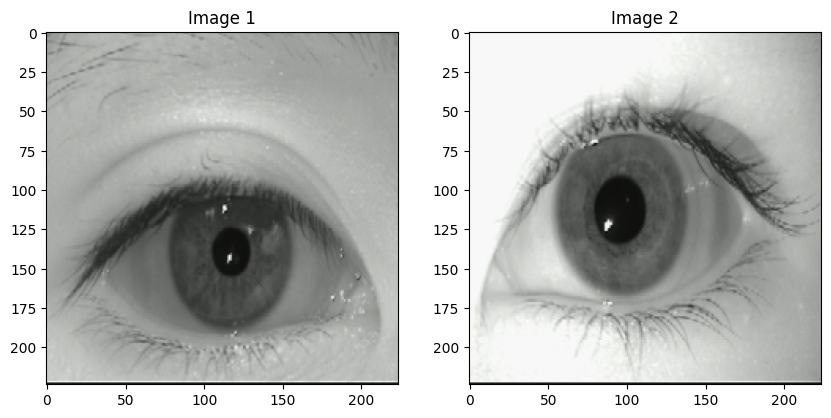

index number:  4
Label: 0.0


index number:  5
Label: 0.0


In [69]:
class SiameseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_folders = [os.path.join(root_dir, d) for d in os.listdir(root_dir)]
        self.image_pairs = self.create_pairs()

    def create_pairs(self):
      pairs = []
      for i, folder in enumerate(self.image_folders):
          images = [os.path.join(folder, img) for img in os.listdir(folder)]
          # Create positive pairs
          for j in range(5):
              pairs.append((images[j], images[j+5], 1))  # Positive pair
          # Create negative pairs
          other_folders = self.image_folders[:i] + self.image_folders[i+1:]
          for other_folder in other_folders:
              other_images = [os.path.join(other_folder, img) for img in os.listdir(other_folder)]
              for j in range(5):
                  pairs.append((images[j], other_images[j], 0))  # Negative pair
      random.shuffle(pairs)
      return pairs

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.image_pairs[idx]
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.tensor(label, dtype=torch.float32)

# Usage:
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
dataset = SiameseDataset(root_dir='MMU-Iris-Database', transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print_number = 0
print(len(dataset))
# Get the images and label at index x
for i in range(len(dataset)):
    img1, img2, label = dataset[i]
    if int(label.item()) == 0:
        print("index number: ",i)
        # Convert tensors to numpy arrays for visualization
        img1 = img1.numpy().transpose((1, 2, 0))
        img2 = img2.numpy().transpose((1, 2, 0))

        # Create a subplot
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Show the images
        axs[0].imshow(img1)
        axs[0].set_title('Image 1')

        axs[1].imshow(img2)
        axs[1].set_title('Image 2')

        # Display the label
        print(f'Label: {label.item()}')

        # Show the plot
        plt.show()
        print_number += 1
        if print_number > 5:
            break

In [ ]:
# Get the first batch
# images, labels = next(iter(siamese_dataloader))

# # Function to unnormalize and display an image
# def imshow(img):
#     img = img / 2 + 0.5  # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # Display images
# imshow(torchvision.utils.make_grid(images))

# # Print labels
# print(' '.join('%5s' % labels[j] for j in range(len(labels))))

# Part 3
#### Implementing CNN model

In [64]:
class SiameseModel(nn.Module):
    def __init__(self):
        super(SiameseModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=11, stride=1, padding=5)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.relu5 = nn.ReLU()
        self.fc1 = nn.Linear(12544, 1000)
        self.fc2 = nn.Linear(1000, 45)

    def forward_one(self, x):
        y = self.conv1(x)
        y = self.bn1(y)
        y = self.relu1(y)
        y = self.pool1(y)

        y = self.conv2(y)
        y = self.bn2(y)
        y = self.relu2(y)
        y = self.pool2(y)

        y = self.conv3(y)
        y = self.bn3(y)
        y = self.relu3(y)
        y = self.pool3(y)

        y = self.conv4(y)
        y = self.bn4(y)
        y = self.relu4(y)
        y = self.pool4(y)

        y = self.flatten(y)
        y = self.fc1(y)
        y = self.relu5(y)
        y = self.fc2(y)

        return y

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2


# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Part 4
#### Creating an object from the model and Implementation of optimizer and loss function

In [65]:
# CNNmodel
model = SiameseModel()
criterion = ContrastiveLoss()
# optimizer
optimizer = SGD(model.parameters(), lr=0.001)

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SiameseModel(
  (conv1): Conv2d(3, 16, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4)

# Part 5
#### Train Time

In [85]:
train_losses = []
num_epochs = 2
all_batches = len(train_loader)
batch_number = 0
# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        start_time = time.time()
        img1, img2, labels = data
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs1, outputs2 = model(img1, img2)
        loss = criterion(outputs1, outputs2, labels)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        end_time = time.time()
        elapsed_time = end_time - start_time
        batch_number += 1
        print(f'Epoch [{epoch+1}/{num_epochs}], batch [{batch_number+1}/{all_batches*num_epochs}] Loss: {loss.item():.6f}, Elapsed_time: {elapsed_time:.5f}')

print('Finished Training')

Epoch [1/2], batch [2/634] Loss: 0.222742, Elapsed_time: 6.87105
Epoch [1/2], batch [3/634] Loss: 0.192065, Elapsed_time: 7.94047
Epoch [1/2], batch [4/634] Loss: 0.124752, Elapsed_time: 9.36180
Epoch [1/2], batch [5/634] Loss: 0.207728, Elapsed_time: 6.18036
Epoch [1/2], batch [6/634] Loss: 0.139002, Elapsed_time: 7.64763
Epoch [1/2], batch [7/634] Loss: 0.130450, Elapsed_time: 6.53093
Epoch [1/2], batch [8/634] Loss: 0.193380, Elapsed_time: 7.88827
Epoch [1/2], batch [9/634] Loss: 0.123787, Elapsed_time: 6.76590
Epoch [1/2], batch [10/634] Loss: 0.146210, Elapsed_time: 8.18100
Epoch [1/2], batch [11/634] Loss: 0.275340, Elapsed_time: 7.41423
Epoch [1/2], batch [12/634] Loss: 0.203126, Elapsed_time: 6.97026
Epoch [1/2], batch [13/634] Loss: 0.188906, Elapsed_time: 8.24441
Epoch [1/2], batch [14/634] Loss: 0.135092, Elapsed_time: 6.67512
Epoch [1/2], batch [15/634] Loss: 0.367584, Elapsed_time: 8.03464
Epoch [1/2], batch [16/634] Loss: 0.116814, Elapsed_time: 6.85112
Epoch [1/2], batch

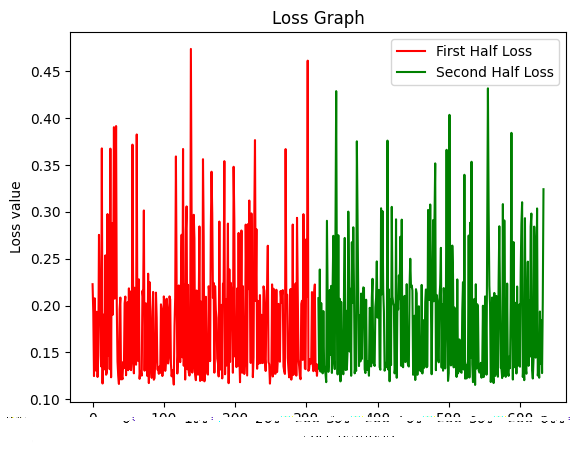

In [86]:
train_losses_number = list(range(len(train_losses)))

# Divide train_losses_number by two
half = len(train_losses_number) // 2

# Create two lists for the first half and the second half
first_half = train_losses_number[:half]
second_half = train_losses_number[half:]

# Similarly divide the train_losses into two halves
first_half_losses = train_losses[:half]
second_half_losses = train_losses[half:]

# Plot the first half in red
plt.plot(first_half, first_half_losses, label='First Half Loss', color='red')

# Plot the second half in green
plt.plot(second_half, second_half_losses, label='Second Half Loss', color='green')

plt.xlabel('Loss numbers')
plt.ylabel('Loss value')
plt.title('Loss Graph')
plt.legend()

plt.show()


# Part 7
#### Saving model

In [87]:
# find Best epoch

print("Minimum Index position: ",train_losses.index(min(train_losses))+1)

Minimum Index position:  538


In [88]:
# saving the model
torch.save(model.state_dict(), 'model_1.pt')

In [89]:
import shutil
shutil.copy2('model_1.pt', '/content/drive/MyDrive/model_1_siamese.pt')

'/content/drive/MyDrive/model_1_siamese.pt'

In [93]:
# Load the saved weights
model = SiameseModel()
model.load_state_dict(torch.load('model_1.pt'))
model.to(device)


# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load and preprocess two images
image_path1 = '1.png'
image_path2 = '2.png'

img1 = transform(Image.open(image_path1).convert('RGB')).unsqueeze(0)
img2 = transform(Image.open(image_path2).convert('RGB')).unsqueeze(0)

# Calculate the distance
with torch.no_grad():
    img1, img2 = img1.to(device), img2.to(device)
    output1, output2 = model(img1, img2)

    # Calculate the Euclidean distance
    euclidean_distance = nn.functional.pairwise_distance(output1, output2)

# Print the calculated distance
print(f"The Euclidean distance between the two images is: {euclidean_distance.item():.4f}")

The Euclidean distance between the two images is: 0.7933


In [ ]:
exit()